# Projet

Le projet consiste à prévoir le nombre de vélos loués à chaque heure dans des bornes libres-services de la ville (système type Vélib'). La variable cible est ici la variable **count**.

Voici un descriptif de l'ensemble des variables :
* *datetime* - date et heure du relevé 
* *season* - 1 = printemps , 2 = été, 3 = automne, 4 = hiver 
* *holiday* – indique si le jour est un jour de vacances scolaires 
* *workingday* - indique si le jour est travaillé (ni week-end ni vacances) 
* *weather* - 1: Dégagé à nuageux, 2 : Brouillard, 3 : Légère pluie ou neige, 4 : Fortes averses ou neiges 
* *temp* – température en degrés Celsius 
* *atemp* – température ressentie en degrés Celsius 
* *humidity* – taux d’humidité 
* *windspeed* – vitesse du vent 
* *casual* - nombre de locations d’usagers non abonnés 
* *registered* – nombre de locations d’usagers abonnés 
* *count* – nombre total de locations de vélos 

Faire attention, dans ce genre de problèmes, à certains points :
- quel type de problème dois-je traiter ?
- feature engineering : est-ce que j'utilise les données correctement, toutes les données ?
- data leakage : est-ce qu'une de mes features n'est pas trop explicative ?
- ai-je bien traité toutes les données correctement ?
- est-ce que mon modèle est adapté ?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Lecture des données et formulation de la problématique

In [2]:
df = pd.read_csv("../data/input/velo.csv")
print("Cette base de données est constituée de ",df.shape[0]," lignes et de ", df.shape[1], " colonnes.")
df.head()

Cette base de données est constituée de  10886  lignes et de  12  colonnes.


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


La variable cible est la variable **count** qui est une variable continue.

Nous allons epxloiter le jeu de données *velo.csv*, qui contient 10 886 lignes, pour nous permettre d'élaborer un modèle de prédiction du nombre total de locations de vélos à chaque heure.

Nous sommes donc face à une problématique **d'apprentissage supervisé dans le cas d'une variable cible continue**.

## Préparation des données

Dans cette partie, nous analyserons les points suivants :

    1. Suppression des variables non nécessaires à l'analyse
    2. Vérification du typage des données
    3. Traitement des valeurs manquantes
    4. Feature engineering : création de nouvelles variables à partir de celles existantes

### 1. Suppression des variables non nécessaires à l'analyse

Parmi les 11 variables explicatives, nous pouvons à priori en supprimer déjà 2, qui sont les suivantes : *casual* et *registered*.

En effet, la variable cible *count* est la somme de ces 2 variables : ce ne sont donc pas des variables explicatives à proprement parler dans le sens où il s'agit d'une décomposition de la variable cible en deux catégories.

En pratique, ces deux variables résultent de la connaissance de la variable cible et de la typologie de l'usager (ou le contraire, mais ce n'est pas dans notre périmètre).

De plus, la variable *temp* et la variable *atemp* sont dépendantes : physiquement la température ressentie dépend de la température et de la vitesse du vent, qui est aussi une variable dans notre jeu de données. Nous allons pour l'instant garder ces 2 variables, afin d'étudier les corrélations plus loin dans le notebook.

In [3]:
# Nous supprimons les colonnes "casual" et "registered"
df = df.drop(["casual","registered"], axis=1)

# Affichons 10 lignes du dataframe prise au hasard
df.sample(10,  random_state=1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
3709,2011-09-05 11:00:00,3,1,0,2,28.70,33.335,74,11.0014,308
6741,2012-03-18 04:00:00,1,0,0,2,17.22,21.210,94,11.0014,14
9848,2012-10-14 17:00:00,4,0,0,1,26.24,31.060,44,12.9980,539
1410,2011-04-04 15:00:00,2,0,1,1,31.16,33.335,23,36.9974,143
10672,2012-12-11 02:00:00,4,0,1,2,16.40,20.455,66,22.0028,1
2999,2011-07-13 21:00:00,3,0,1,1,28.70,33.335,79,7.0015,250
1433,2011-04-05 14:00:00,2,0,1,2,14.76,15.910,57,32.9975,76
9129,2012-09-03 18:00:00,3,1,0,1,30.34,34.850,66,11.0014,482
7446,2012-05-09 15:00:00,2,0,1,2,26.24,31.060,53,7.0015,259
4523,2011-11-01 13:00:00,4,0,1,1,19.68,23.485,55,12.9980,167


Remarquons que cet échantillon de 10 lignes nous a permis de mettre en évidence une erreur dans la définition de l'une des variables : la variable *season*.

En effet, nous avons par exemple pour l'id 2999 une valeur *season* égale à 3 qui correspond d'après le dictionnaire à la saison de l'automne, alors que nous devrions trouver la valeur 2, étant le 13/07. En prenant quelques autres valeurs, nous remarquons qu'il y'a eu une mauvaise définition des saisons associées aux valeurs.

**Redéfinissons donc la description de cette variable** ->  *season* - 1 = hiver  , 2 = printemps, 3 = été, 4 = automne


### 2. Vérification du typage des données

Nous allons vérifier tous les types de données afin de nous assurer que les données catégorielles soient considérées en tant que telles par Python, et que la variable cible soit bien une variable numérique.

In [4]:
# Type de données 
df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
count           int64
dtype: object

Nous devons changer certains types de données. 

En effet, les variables suivantes sont des variables catégorielles, d'après le dictionnaire des données fournit au début de ce jeu de données : *season*, *holiday*, *workingday*, *weather*.

Nous pouvons également le vérifier en calculant le nombre de valeurs distinctes par variables explicatives, ce que je vais faire dans la cellule suivante.

In [5]:
for colname, serie in df.iteritems():
    print(colname + " has " + str(serie.drop_duplicates().shape[0]) + " unique values.")

datetime has 10886 unique values.
season has 4 unique values.
holiday has 2 unique values.
workingday has 2 unique values.
weather has 4 unique values.
temp has 49 unique values.
atemp has 60 unique values.
humidity has 89 unique values.
windspeed has 28 unique values.
count has 822 unique values.


Nous remarquons également grâce à cette analyse, que **la variable datetime est inexploitable car ne possède que des valeurs uniques**. 

Or, cette variable contient entre autre l'information sur l'heure, information essentielle dans notre problème. Nous verrons comment palier à ce problème dans le point n°4. 

Pour l'heure, transformons les 4 variables sus-citées en variables catégorielles.

In [6]:
df["season"] = pd.Categorical(df["season"])
df["holiday"] = pd.Categorical(df["holiday"])
df["workingday"] = pd.Categorical(df["workingday"])
df["weather"] = pd.Categorical(df["weather"])

In [7]:
# Vérifions que le type de données a bien été mis à jour
df.dtypes

datetime        object
season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
count            int64
dtype: object

### 3. Traitement des valeurs manquantes et des valeurs aberrantes

Les valeurs manquantes sont à traiter impérativement afin d'avoir un jeu de données le plus exhautif possible.

Nous pouvons également vérifier la présence d'outliers, qui peuvent être problématiques dans certaines modélisations. 

In [8]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
dtype: int64

Il n'y a à priori pas de valeur manquante, d'après la description du jeu de données. Nous n'avons donc pas d'imputation à effectuer.

Maintenant, calculons le nombre de données de la variable cible considérées comme des outliers.
Pour ce faire, créeons d'abord une boîte à moustache pour visualer la valeure seuil, puis calculons la.

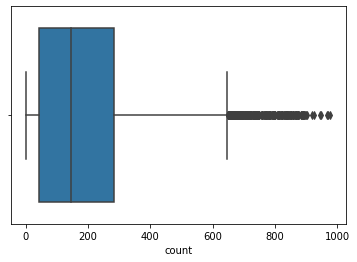

In [9]:
import seaborn as sns
sns.boxplot(x=df['count'])

In [10]:
#Calcul du seuil
Q1 = df['count'].quantile(0.25)
Q3 = df['count'].quantile(0.75)
IQR = Q3 - Q1
seuil = 1.5*IQR + Q3
print("A partir de ",seuil,", la variable 'count' est considérée comme un outlier")

A partir de  647.0 , la variable 'count' est considérée comme un outlier


In [11]:
print("Pourcentage du jeu de données considérées comme des données 'outliers' :\n {:.1f} \n".format(
    100*(df[df['count']>= seuil].shape[0])/df.shape[0]))

print("Nombre de lignes du jeu de données considérées comme des données 'outliers' :\n {:.0f}".format(
    (df[df['count']>= seuil].shape[0])))

Pourcentage du jeu de données considérées comme des données 'outliers' :
 2.8 

Nombre de lignes du jeu de données considérées comme des données 'outliers' :
 303


Moins de 3% du jeu de données est considérées comme 'hors-norme'. Nous allons garder ces données afin de voir leur influence sur les modèles que nous allons mettre en place.

### 4. Feature engineering : création de nouvelles variables

Revenons à la variable *datetime* inexploitable en l'état car elle correspond à l'identifiant du jeu de données, afin de remonter à la période de la prise d'acquisition de la donnée.

Or, cette variable contient d'autres variables très intéressantes que nous allons extraire pour en savoir plus sur le jeu de données, et en utiliser certaines comme variable explicative.

L'heure est une variable explicative nécessaire à l'exploration et l'entrainement du modèle.

In [12]:
df['month'] = pd.DatetimeIndex(df['datetime']).month
df['day'] = pd.DatetimeIndex(df['datetime']).day
df['hour'] = pd.DatetimeIndex(df['datetime']).hour

In [13]:
# Supression de la variable "datetime"
df = df.drop(["datetime"], axis=1)

In [14]:
df.describe()

,temp,atemp,humidity,windspeed,count,month,day,hour
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,191.574132,6.521495,9.992559,11.541613
std,7.79159,8.474601,19.245033,8.164537,181.144454,3.444373,5.476608,6.915838
min,0.82000,0.760000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500,42.000000,4.000000,5.000000,6.000000
50%,20.50000,24.240000,62.000000,12.998000,145.000000,7.000000,10.000000,12.000000
75%,26.24000,31.060000,77.000000,16.997900,284.000000,10.000000,15.000000,18.000000
max,41.00000,45.455000,100.000000,56.996900,977.000000,12.000000,19.000000,23.000000


Nous remarquons ainsi que les acquisitions ont lieu du 1 au 19 de chaque mois.
Nous allons supprimer cette variable car les variables *holiday* et *workingday* apportent plus d'informations dans le cadre de cette problématique que la variable *day* qui ne porte pas d'informations utiles.

In [15]:
# Supression de la variable "day"
df = df.drop(["day"], axis=1)

In [16]:
df.dtypes

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
count            int64
month            int64
hour             int64
dtype: object

Les deux nouvelles variables explicatives sont au format 'int64' : nous allons garder ce format pour la suite.

## Exploration des données

### 1. Exploration univariée

Une exploration univariée nous permettra d'obtenir davantage d'informations sur nos différentes variables explicatives.

Notamment au niveau de potentiels déséquilibres dans la représantativité sur notre jeu de données.

Commençons par explorer les variables catégorielles en traçant des diagrammes en barre. Nous allons en ordonnée représenter la fréquence d'apparition en pourcentage.

#### Variables catégorielles

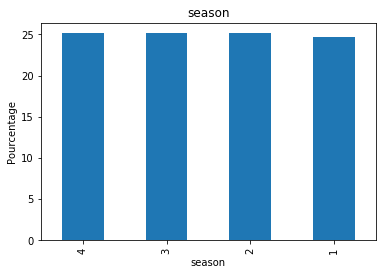

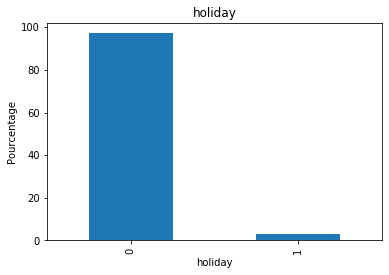

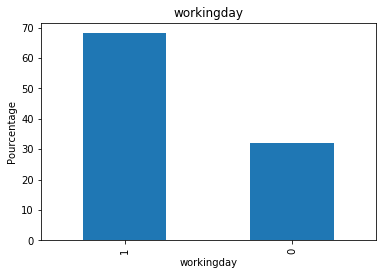

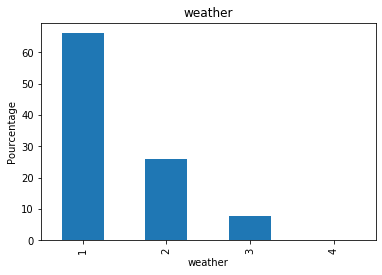

In [17]:
for colname, serie in df.iteritems():
    if serie.dtype.name is 'category':
        (100*serie.value_counts()/df.shape[0]).plot(kind="bar")
        plt.title(colname)
        plt.xlabel(colname)
        plt.ylabel("Pourcentage")
        plt.show()

In [18]:
# Pourcentage d'apparition de chaque valeur de la variable "holiday"
round(100*df.holiday.value_counts()/ df.shape[0],2)

0    97.14
1     2.86
Name: holiday, dtype: float64

In [19]:
# Nombre apparition de chaque valeur de la variable "weather"
df.weather.value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

Nous pouvons effectuer 2 observations : 

   • Variable *holiday* : il y'a un très fort désequilibre entre les deux valeurs -> Cela était en effet attendu, le nombre de jours de vacances étant relativement faible par rapport au nombre de jours dans l'année. Malgré ce déséquilibre, nous pouvons intuiter et partir du postulat que cette variable a un pouvoir explicatif fort. Nous vérifierons cela lors de l'analyse bivariée.
    
   • Variable *weather* : la valeur 4 n'apparrait qu'une seule fois -> Nous pouvons nous demander s'il est pertinent de garder la ligne contenant cette valeur. Nous allons supprimer la ligne en question via la commande ci-dessous.

In [20]:
i = df[((df.weather == 4))].index
df = df.drop(i)
df.weather =  df.weather.cat.remove_unused_categories()
print(df.weather.unique())

[1, 2, 3]
Categories (3, int64): [1, 2, 3]


In [21]:
# Nous vérifions que nous avons bien 10 885 lignes 
df.shape

(10885, 11)

#### Variables non catégorielles

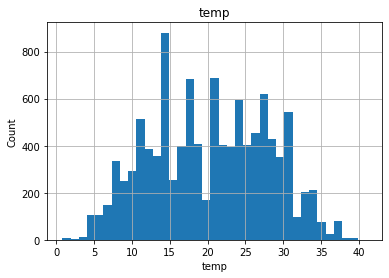

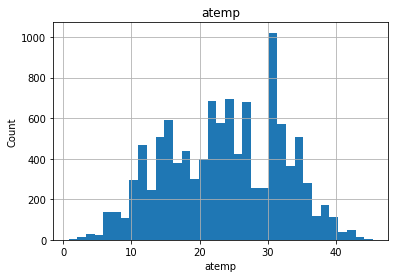

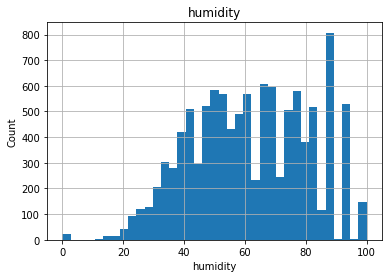

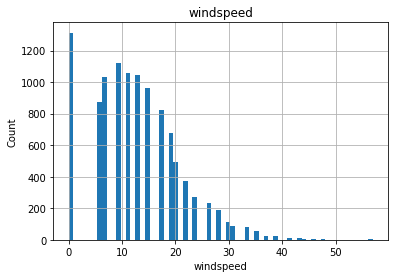

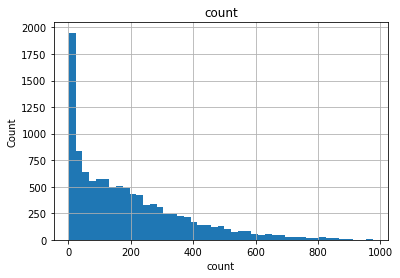

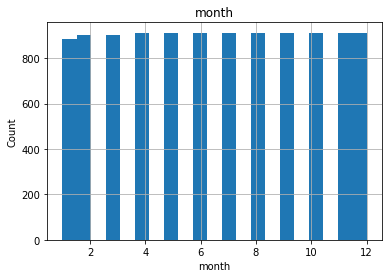

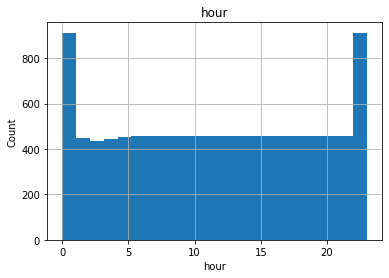

In [22]:
for colname, serie in df.iteritems():
    if serie.dtype.name is not 'category':
        serie.hist(bins='auto')
        plt.title(colname)
        plt.xlabel(colname)
        plt.ylabel("Count")
        plt.show()

Suite à ces tracés, nous pouvons commenter plusieurs points :

La variable *count* n'est pas distribuée selon une loi normale, ni centrée : comme nous l'avons vu précédemment, il y'a très peu de valeurs au dessus de la valeur 647. En cumulé, 97% des données se trouvent sous ce seuil.

Les variables *temp* et *atemp* semblent suivre une même loi, comme intuitée au début de ce notebook.

### 2. Exploration bivariée


L'exploration bivariée nous permet de représenter l'influence de chaque variable explicvative sur la variable cible.

#### Variables catégorielles


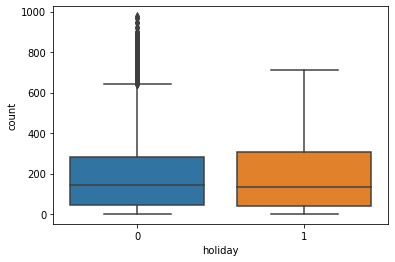

In [23]:
sns.boxplot(x="holiday", y="count", data=df)
plt.show()

Il semble qu'il y'ait un nombre légèrement plus élevé de location de vélos lors des vacances.

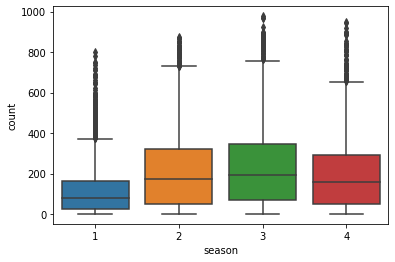

In [24]:
sns.boxplot(x="season", y="count", data=df)
plt.show()

La saison influence le nombre de location de vélos : été > printemps > automne > hiver

Cela correspond à ce que l'on pourrait à priori s'attendre. La saison corrèle généralement avec la température, l'humidité et la météo qui sont des facteurs essentiels pour le cycliste.

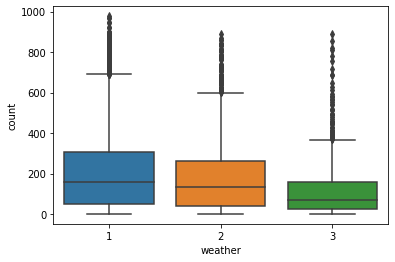

In [25]:
sns.boxplot(x="weather", y="count", data=df)
plt.show()

Plus la météo se dégrade, moins il y'a de location de vélos, ce qui semble logique.

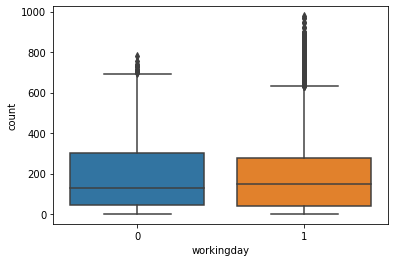

In [26]:
sns.boxplot(x="workingday", y="count", data=df)
plt.show()

La moyenne est plus élevée lors des jours de travail, et la distribution plus concentrée : cela pourrait s'interpréter comme la régularité des personnes prenant le vélo comme moyen de locomotion de leur domicile vers leur lieu de travail.

#### Variables non catégorielles


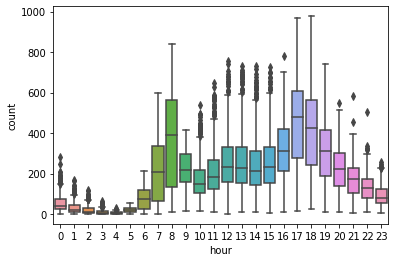

In [27]:
sns.boxplot(x="hour", y="count", data=df)
plt.show()

Le nombre de location de vélos est répartie dans une journée avec deux périodes pleines et deux creuses.

En effet, de 7h à 9h, et de 16h à 19h, nous atteignons deux pics. Nous pouvons l'interpréter comme les heures de pointe où les utilisateurs se rendent de leur domicile à leur lieu de travail, et vice-versa.

Cette interprétation est renforcée par le fait que 70% du jeu de données correspond à des mesures lors d'une journée travaillée.

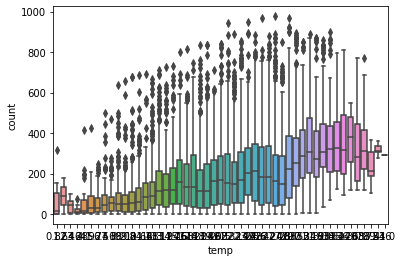

In [28]:
sns.boxplot(x="temp", y="count", data=df)
plt.show()

Le nombre de locations de vélo en fonction de la température semble suivre une loi linéaire, ce qui semble normale. Le froid est un facteur dissuassif de l'utilisation du vélo.

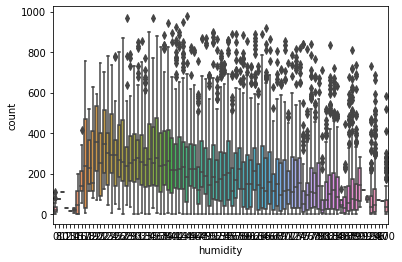

In [29]:
sns.boxplot(x="humidity", y="count", data=df)
plt.show()

Le nombre de locations de vélo en fonction de l'humidité semble également suivre une loi linéaire : plus l'humidité est élevée et moins le vélo est utilisé. Cela correspond également au bon sens physique que nous pouvons associer à cette augmentation de l'humidité sur l'agréabilité de l'utilisation du vélo.

### 3. Exploration multivariée

L'exploration multivariée est essentielle afin de nous représenter les corrélations 2 à 2 des différentes variables, et l'influence de ces corrélations sur la variable cible.

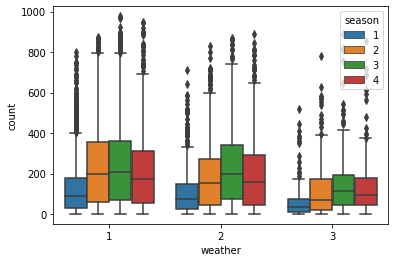

In [30]:
sns.boxplot(x="weather", y="count", hue="season", data=df)
plt.show()

Nous pouvons visualiser le nombre de location de vélos suit une même loi entre les différentes saisons, et que la météo est un facteur multiplicateur de ce nombre de location.

Penchons-nous sur la corrélations des différentes variables continues.

In [31]:
df.corr()

,temp,atemp,humidity,windspeed,count,month,hour
temp,1.000000,0.984945,-0.064783,-0.017973,0.394476,0.257420,0.145584
atemp,0.984945,1.000000,-0.043376,-0.057591,0.389802,0.264016,0.140486
humidity,-0.064783,-0.043376,1.000000,-0.318544,-0.317377,0.204760,-0.278150
windspeed,-0.017973,-0.057591,-0.318544,1.000000,0.101361,-0.150337,0.146713
count,0.394476,0.389802,-0.317377,0.101361,1.000000,0.166860,0.400631
month,0.257420,0.264016,0.204760,-0.150337,0.166860,1.000000,-0.006681
hour,0.145584,0.140486,-0.278150,0.146713,0.400631,-0.006681,1.000000


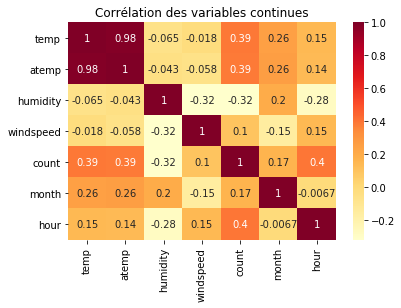

In [32]:
sns.heatmap(df.corr(), cmap="YlOrRd", annot=True)
plt.title("Corrélation des variables continues")
plt.show()

Comme remarqué depuis le début de l'exercice, les variables *temp* et *atemp* sont très fortement corrélés et contiennent donc le même pouvoir explicatif sur la variable cible.

Nous allons donc supprimer la variable *atemp*.

Les variables les plus corrélées à notre variable cible sont les suivantes : *hour*, *temp* et *humidity*. Leur corrélation est inférieure à 0.8, elles sont donc toutes intéressantes pour expliquer la variable cible.

# Preprocessing pour scikit-learn

Nous allons préparer le jeu de données pour qu'il soit exploitable dans la phase d'entrainement et de test des modèles.

Le principal point d'attention concerne les variables catégorielles. 

In [33]:
categorical_features = df.columns[df.dtypes == "category"].tolist()
print(categorical_features)

['season', 'holiday', 'workingday', 'weather']


In [34]:
df[categorical_features].sample(5, random_state=1)

,season,holiday,workingday,weather
3709,3,1,0,2
6741,1,0,0,2
9848,4,0,0,1
1410,2,0,1,1
10672,4,0,1,2


In [35]:
df_dummies = pd.get_dummies(df[categorical_features])
df_dummies.head()

,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_1,weather_2,weather_3
0,1,0,0,0,1,0,1,0,1,0,0
1,1,0,0,0,1,0,1,0,1,0,0
2,1,0,0,0,1,0,1,0,1,0,0
3,1,0,0,0,1,0,1,0,1,0,0
4,1,0,0,0,1,0,1,0,1,0,0


In [36]:
# on concatène ensuite avec le dataset original
df = pd.concat([df.drop(categorical_features, axis=1), df_dummies], axis=1)
df.sample(5, random_state=1)

,temp,atemp,humidity,windspeed,count,month,hour,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_1,weather_2,weather_3
3709,28.70,33.335,74,11.0014,308,9,11,0,0,1,0,0,1,1,0,0,1,0
6741,17.22,21.210,94,11.0014,14,3,4,1,0,0,0,1,0,1,0,0,1,0
9848,26.24,31.060,44,12.9980,539,10,17,0,0,0,1,1,0,1,0,1,0,0
1410,31.16,33.335,23,36.9974,143,4,15,0,1,0,0,1,0,0,1,1,0,0
10672,16.40,20.455,66,22.0028,1,12,2,0,0,0,1,1,0,0,1,0,1,0


In [37]:
X = df.drop(["count"], axis=1)
y = df["count"]

In [38]:
print(X.shape)

(10885, 17)


Nous avons ici créé des variables indicatrices pour chaque variable catégorielles.
Notre jeu contient désormais 17 variables explicatives en prenant en compte ces variables indicatrices.

# Choix et entrainement de modèles d'apprentissage supervisé


In [39]:
from sklearn.model_selection import train_test_split
from pylab import rcParams
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1 )
print("Train dimension :", X_train.shape)
print("Test dimension :", X_test.shape)

Train dimension : (8708, 17)
Test dimension : (2177, 17)


## Un modèle de base : la régression linéaire

### Régression linéaire simple


In [40]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
pred_train = reg.predict(X_train)
pred_test = reg.predict(X_test)

In [41]:
print("Le score du jeu d'entrainement est de : {:.2f}".format(reg.score(X_train, y_train)))
print("Le score du jeu de test est de : {:.2f}".format(reg.score(X_test, y_test)))

Le score du jeu d'entrainement est de : 0.35
Le score du jeu de test est de : 0.33


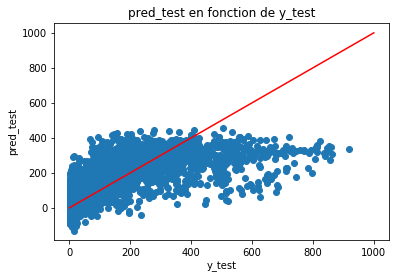

In [42]:
abscisse = np.linspace(0,1000,1000)
ordonnee = abscisse
pred_test = reg.predict(X_test)
plt.scatter(y_test,pred_test)
plt.xlabel('y_test')
plt.ylabel('pred_test')
plt.title('pred_test en fonction de y_test')
plt.plot(abscisse,ordonnee, color='red')
plt.rcParams["figure.figsize"] = [10,9]

Le score est très faible sur ce modèle de régression linéaire simple.

Après avoir tracé la courbe du label prédit en fonction du vrai label sur le jeu de test, nous pouvons remarqué que les valeurs considérées comme des 'outliers' sont très sous-estimés : le modèle dérive complètement notamment à cause de ces valeurs.

Remarquons également que le modèle nous renvoie des valeurs négatives pour un comptage, ce qui n'a pas de sens.

Testons alors ce même modèle en enlevant les 3 % du jeu de données considérées comme des 'outliers' 

### Régression linéaire simple en ne considérant plus les 'outliers'

Supprimons les 'outliers' de notre jeu de données

In [43]:
X = df.drop(["count"], axis=1)
X= X.drop(df[df['count'] >= seuil].index)
X.shape

(10582, 17)

In [44]:
y = df["count"]
y = y.drop(df[df['count'] >= seuil].index)
y.shape

(10582,)

Maintenant, refaisons un split avec le même seed que précédemment : le jeu de données étant réduit, nous n'aurons pas tout à fait les mêmes données.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1 )

In [46]:
reg = LinearRegression().fit(X_train, y_train)
pred_train = reg.predict(X_train)
pred_test = reg.predict(X_test)

In [47]:
print("Le score du jeu d'entrainement est de : {:.2f}".format(reg.score(X_train, y_train)))
print("Le score du jeu de test est de : {:.2f}".format(reg.score(X_test, y_test)))

Le score du jeu d'entrainement est de : 0.37
Le score du jeu de test est de : 0.37


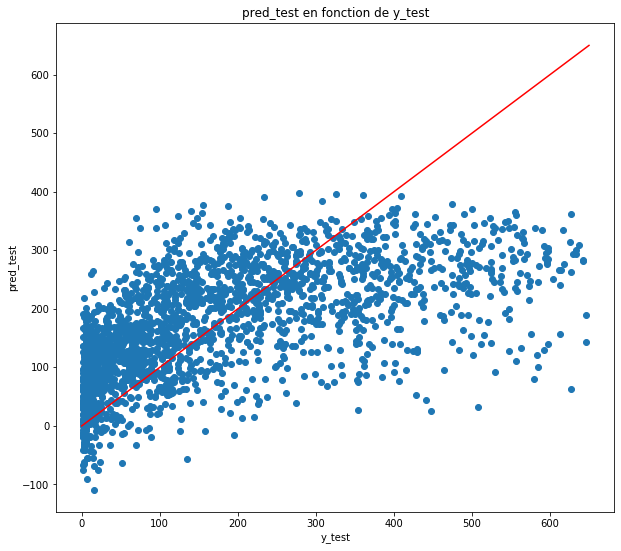

In [48]:
abscisse = np.linspace(0,650)
ordonnee = abscisse
pred_test = reg.predict(X_test)
plt.scatter(y_test,pred_test)
plt.xlabel('y_test')
plt.ylabel('pred_test')
plt.title('pred_test en fonction de y_test')
plt.plot(abscisse,ordonnee, color='red')
plt.rcParams["figure.figsize"] = [10,9]

Ce modèle reste très peu performant malgré l'absence des 'outliers'.

Il se peut qu'il ne soit pas adapté à ce genre de problématique où nous avons des séries temporelles : nous pouvons nous représenter le fait que le nombre de locations de vélo suive une trajectoire sinusoidale le long de la journée (alternance heures creuses et heures de pointe), et le long des saisons comme nous l'avons vu lors de l'analyse exploratoire.

Essayons tout de même d'améliorer notre modèle avant de passer à un modèle plus sophistiqué, en effectuant une validation croisée.

### Régression linéaire simple en ne considérant plus les 'outliers' et avec cross-validation


In [49]:
from sklearn.model_selection import cross_val_score
reg = LinearRegression()
scores_train = cross_val_score(reg, X_train, y_train, scoring='r2', cv=10)
scores_test = cross_val_score(reg, X_test, y_test, scoring='r2', cv=10)
print("Le score moyen du jeu d'entrainement est de : {:.2f}".format(np.mean(scores_train)))
print("Le score moyen du jeu de test est de : {:.2f}".format(np.mean(scores_test)))

Le score moyen du jeu d'entrainement est de : 0.37
Le score moyen du jeu de test est de : 0.36


La validation croisée ne permet pas d'améliorer la performance du modèle.

Il n'est pas nécessaire d'aller pluis loin, en effectuant par exemple une régulation. En effet, ce modèle est déjà très peu attaché aux données, une régularisation n'a donc pas de sens ici.

## Un deuxième modèle : le Random Forest

### RandomForestRegressor

Nous allons reconsidérer ici les 'outliers' dans un premier temps

In [50]:
from sklearn.ensemble import RandomForestRegressor
X = df.drop(["count"], axis=1)
y = df["count"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
rfg = RandomForestRegressor(n_jobs=-1,random_state = 1)
rfg.set_params(n_estimators=50)
rfg.fit(X_train, y_train)
print("Le score moyen du jeu d'entrainement est de : {:.2f}".format(rfg.score(X_train,y_train)))
print("Le score moyen du jeu de test est de : {:.2f}".format(rfg.score(X_test, y_test)))

Le score moyen du jeu d'entrainement est de : 0.98
Le score moyen du jeu de test est de : 0.86


Nous pouvons remarquer une nette amélioration de la performance sur ce modèle, alors que les hyper-paramètres n'ont pas encore été optimisés, et que les 'outliers' ont été pris en compte.

Remarquons que le modèle se dégrade entre l'entrainement et le test : il semblerait que nous soyons dans un cas de sur-apprentissage.

Faisons alors une validation croisée pour le vérifier.

In [52]:
scores_train = cross_val_score(rfg, X_train, y_train,cv=5)
scores_test = cross_val_score(rfg, X_test, y_test, cv=5)
print("Le score moyen du jeu d'entrainement est de : {:.2f}".format(np.mean(scores_train)))
print("Le score moyen du jeu de test est de : {:.2f}".format(np.mean(scores_test)))
print(scores_train)
print(scores_test)

Le score moyen du jeu d'entrainement est de : 0.85
Le score moyen du jeu de test est de : 0.81
[0.86021607 0.8464909  0.83839898 0.84938691 0.84305878]
[0.81252357 0.78969061 0.81847456 0.85171026 0.75927975]


Nous obtenons ainsi un écart relativement moindre entre le score sur le jeu d'entrainement et le jeu de test.

Remarquons néanmoins quer la performance du modèle a diminué au global.

Recherchons à optimiser quelques hyper-paramètres afin d'obtenir un meilleur modèle.

Commençons par le nombre d'arbres, associé à une validation croisée avec 5 plis.

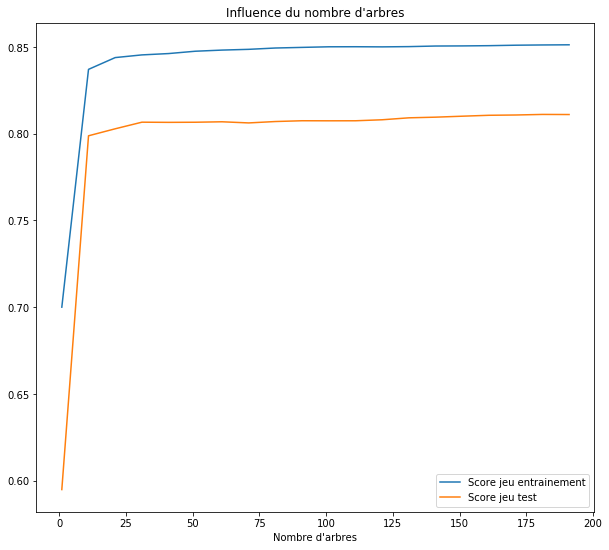

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
rfg = RandomForestRegressor(n_jobs=-1,random_state = 1)
estimators = np.arange(1, 200, 10)
scores_train=[]
scores_test = []
for n in estimators:
    rfg.set_params(n_estimators=n)
    rfg.fit(X_train, y_train)
    scores_train.append(np.mean(cross_val_score(rfg, X_train, y_train,cv=5))) # Nous effectuons une validation croisée pour obtenir le score
    scores_test.append(np.mean(cross_val_score(rfg, X_test, y_test, cv=5)))
plt.title("Influence du nombre d'arbres")
plt.xlabel("Nombre d'arbres")
plt.plot(estimators, scores_train)
plt.plot(estimators, scores_test)
plt.legend(['Score jeu entrainement','Score jeu test'])

In [54]:
best_n = np.argmax(scores_test)
print(" Nombre d'arbres optimal : ",estimators[best_n])
print(" Meilleur score obtenu en test : {:.3f}".format(scores_test[best_n]))
print(estimators[2])
print(" Score obtenu en test pour 21 arbres : {:.3f}".format(scores_test[2]))

 Nombre d'arbres optimal :  181
 Meilleur score obtenu en test : 0.811
21
 Score obtenu en test pour 21 arbres : 0.803


Nous remarquons qu'à partir d'environ 21 arbres le score ne varie que très peu : il peut être pertinent de partir sur cette valeur pour des raisons de performance, et de regarder l'influence des autres paramètres.

Regardons l'influence des autres hyper-paramètres.

Ci-dessous, nous allons optimiser 6 paramètres à la fois, qui sont les suivants :

*n_estimators* : nombre d'arbres

*max_features* : nombre de variables explicatives maximum

*max_depth* : profondeur maximale des arbres

*min_samples_split* : nombre minimum de données au niveau d'un noeud 

*min_samples_leaf* : nombre minimum de données au niveau d'un échantillon 

*bootstrap* : outil pour utilisation d'un échantillon ou du jeu de données complet pour chaque arbre

In [55]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(10, 110, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,4,6,8,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3,4,5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110, None], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'bootstrap': [True, False]}


In [56]:
rfg_random = RandomizedSearchCV(estimator = rfg,
                                param_distributions = random_grid,
                                n_iter = 50,
                                cv = 5,
                                verbose=2,
                                random_state=1,
                                n_jobs = -1)
rfg_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=191, n_jobs=-1,
                   

In [57]:
# Ci-dessous nous affichons les paramètres optimaux selon les intervalles de départ, arbitraires, et le calcul
# comprenant 50 itérations et 5 plis.
rfg_random.best_params_

{'n_estimators': 76,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 65,
 'bootstrap': True}

In [58]:
# Nous affectons à notre modèle les paramètres optimaux
rfg.set_params(**rfg_random.best_params_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=65, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=76, n_jobs=-1, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [59]:
rfg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=65, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=76, n_jobs=-1, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [60]:
scores_train = cross_val_score(rfg, X_train, y_train,cv=5)
scores_test = cross_val_score(rfg, X_test, y_test, cv=5)
print("Le score moyen du jeu d'entrainement est de : {:.2f}".format(np.mean(scores_train)))
print("Le score moyen du jeu de test est de : {:.2f}".format(np.mean(scores_test)))

Le score moyen du jeu d'entrainement est de : 0.85
Le score moyen du jeu de test est de : 0.81


Nous avons optimisé le modèle. Cependant, ses performances n'ont pas été relativement améliorées.

Traçons la courbe de la prediction en fonction de la valeur réelle.

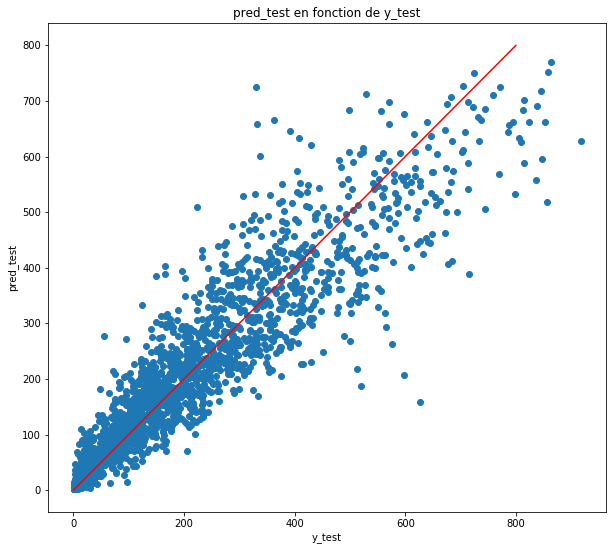

In [61]:
abscisse = np.linspace(0,800)
ordonnee = abscisse
pred_test = rfg.predict(X_test)
plt.scatter(y_test,pred_test)
plt.xlabel('y_test')
plt.ylabel('pred_test')
plt.title('pred_test en fonction de y_test')
plt.plot(abscisse,ordonnee, color='red')
plt.rcParams["figure.figsize"] = [10,9]

Nous observons que ce modèle gère beaucoup mieux les 'outliers'.
C'est un modèle assez performant qui permet d'avoir une très bonne approximation de la variable cible.

### RandomForestRegressor sans prise en compte des 'outliers'


In [62]:
X = df.drop(["count"], axis=1)
X= X.drop(df[df['count'] >= seuil].index)
X.shape

(10582, 17)

In [63]:
y = df["count"]
y = y.drop(df[df['count'] >= seuil].index)
y.shape

(10582,)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
rfg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=65, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=76, n_jobs=-1, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [65]:
scores_train = cross_val_score(rfg, X_train, y_train,cv=5)
scores_test = cross_val_score(rfg, X_test, y_test, cv=5)
print("Le score moyen du jeu d'entrainement est de : {:.2f}".format(np.mean(scores_train)))
print("Le score moyen du jeu de test est de : {:.2f}".format(np.mean(scores_test)))

Le score moyen du jeu d'entrainement est de : 0.84
Le score moyen du jeu de test est de : 0.80


Nous pourrions nous étonné d'obtenir un score plus faible alors que nous avons retiré les outliers.

En fait, les hyper-paramètres sont à nouveau à optimiser comme le jeu de données n'est plus tout à fait le même.

In [66]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(10, 110, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,4,6,8,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3,4,5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110, None], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'bootstrap': [True, False]}


In [67]:
rfg_random = RandomizedSearchCV(estimator = rfg,
                                param_distributions = random_grid,
                                n_iter = 50,
                                cv = 5,
                                verbose=2,
                                random_state=1,
                                n_jobs = -1)
rfg_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   57.6s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=65,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=4,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=76, n_jobs=-1,
                      

In [68]:
rfg_random.best_params_

{'n_estimators': 76,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 65,
 'bootstrap': True}

In [69]:
rfg.set_params(**rfg_random.best_params_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=65, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=76, n_jobs=-1, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [70]:
rfg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=65, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=76, n_jobs=-1, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [71]:
scores_train = cross_val_score(rfg, X_train, y_train,cv=5)
scores_test = cross_val_score(rfg, X_test, y_test, cv=5)
print("Le score moyen du jeu d'entrainement est de : {:.2f}".format(np.mean(scores_train)))
print("Le score moyen du jeu de test est de : {:.2f}".format(np.mean(scores_test)))

Le score moyen du jeu d'entrainement est de : 0.84
Le score moyen du jeu de test est de : 0.80


Finalement, nous obtenons des performances similmaires, avec ou sans 'outliers'.

## Un troisième modèle : le XGBoost

### XGBRegressor

Nous irons moins dans le détail pour ce troisième modèle, où je vais directement optimiser les 4 paramètres suivants à l'aide d'un GridSearch associé à une validation croisée à 5 plis :

*colsample_bytree* : sous-echantillage à utiliser pour chaque 'arbre'  

*min_child_weight*: nombre d'instance minimum pour chaque noeud

*max_depth* : profondeur maximum d'un 'arbre'

*n_estimators* : nombre d'étapes ou de décomposition avant l'aggrégation

In [72]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
X = df.drop(["count"], axis=1)
y = df["count"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
gbm = xgb.XGBRegressor()
reg_cv = GridSearchCV(gbm, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2]
                            ,'max_depth': [3,4,6], 'n_estimators': [500,1000]}, verbose=1)
reg_cv.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_est...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=Non

In [73]:
reg_cv.best_params_

{'colsample_bytree': 1.0,
 'max_depth': 4,
 'min_child_weight': 1.0,
 'n_estimators': 500}

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
gbm = xgb.XGBRegressor(**reg_cv.best_params_)
gbm.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1.0, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [75]:
print("Train score: {:.2f}".format(gbm.score(X_train,y_train)))
print("Test score: {:.2f}".format(gbm.score(X_test,y_test)))

Train score: 0.94
Test score: 0.87


In [76]:
scores_train = cross_val_score(gbm, X_train, y_train,cv=5)
scores_test = cross_val_score(gbm, X_test, y_test, cv=5)
print("Le score moyen du jeu d'entrainement est de : {:.2f}".format(np.mean(scores_train)))
print("Le score moyen du jeu de test est de : {:.2f}".format(np.mean(scores_test)))

Le score moyen du jeu d'entrainement est de : 0.86
Le score moyen du jeu de test est de : 0.80


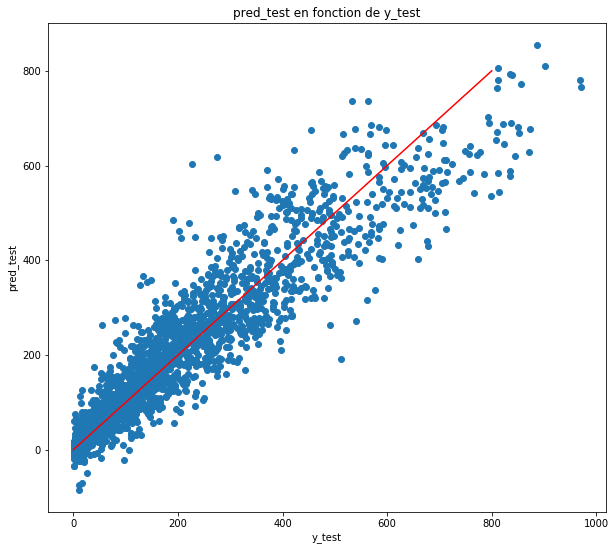

In [77]:
abscisse = np.linspace(0,800)
ordonnee = abscisse
pred_test = gbm.predict(X_test)
plt.scatter(y_test,pred_test)
plt.xlabel('y_test')
plt.ylabel('pred_test')
plt.title('pred_test en fonction de y_test')
plt.plot(abscisse,ordonnee, color='red')
plt.rcParams["figure.figsize"] = [10,9]

Ce modèle donne de très bons résultats comme nous pouvons le voir ci-dessus. 

L'écart se creuse pour les valeurs élevées de la valeur cible. Je pense que cela est due à la distribution de la variable cible, qui fait que le modèle a très peu de données avec des valeurs élevées pour pouvoir être performant. 

Les performances sont à peu près équivalents qu'avec le modèle précédent: ces deux modèles se base sur le même modèle qui est l'arbre de décision

## Conclusion

En conclusion, nous avons testé plusieurs modèles afin de connaitre leurs performances sur notre jeu de données.

La phase de préparation des données et de pré-processing est fondamentale.

Dans cet exercice je n'ai pas retouché au jeu de données, mais j'aurais pu par exemple essayer une autre modélisation du jeu de données (par exemple utiliser l'heure en tant que variable catégorielle, ou retirer la variable *month* qui donne substantiellement la même information que la variable *season*, sans pour autant être trop précis, ce qui peut mener à un sur apprentissage.

La modélisation choisie ne permet pas à un modèle de régression linéaire simple d'avoir une bonne performance.

Il est donc important d'essayer plusieurs modèles avant de conclure à un sous-apprentissage. Je pense que la période cyclique de la variable cible ne permet pas d'avoir une bonne approximation par une régression linéaire.

Il est également important d'optimiser les hyper-paramètres des modèles pour améliorer les performances. Cette phase peut-être très longue, et il n'est pas aisé de savoir dans quels intervals rechercher nos paramètres.

Il peut être intéressant de couvrir une large amplitude au départ, avec un découpage faible, puis, une fois l'intervalle intéressant repéré, faire un découpage plus régulier afin d'obtenir les meilleurs hyper-paramètres.